In [3]:
import numpy as np
import pandas as pd

#Data utils
import quandl
import sqlite3
from sqlite3 import Error

#import datetime as dt

# Our Module
import futsqlite

#plotting
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

quandl.ApiConfig.api_key = "_srX4KQ6xix5aBeij-72"

In [4]:
#Create SQLite database called 'futures_data.db' in working directory
database = 'futures_data.db'
futsqlite.create_db(database)

In [6]:
#read usd_markets_dict (CME dollar denominated markets only with their specifications)
usd_markets = pd.read_csv('usd_markets_dict.csv')
usd_markets.head()

,Exchange,Sym,Months,Start,End,BPV,Price_scale,Currency,Sector
0,CME,C,HKNUZ,1960,2018,50.0,0.125,USD,grains
1,CME,S,FHKNQUX,1970,2018,50.0,0.125,USD,grains
2,CME,W,HKNUZ,1960,2018,50.0,0.125,USD,grains
3,CME,BO,FHKNQUVZ,1961,2018,600.0,0.010,USD,grains
4,CME,SM,FHKNQUVZ,1964,2018,100.0,0.100,USD,grains


In [7]:
#Add slash since that's how symbols are stored in Quandl
usd_markets['Exchange'] = [item + '/' for item in usd_markets['Exchange']]
usd_markets.head()

,Exchange,Sym,Months,Start,End,BPV,Price_scale,Currency,Sector
0,CME/,C,HKNUZ,1960,2018,50.0,0.125,USD,grains
1,CME/,S,FHKNQUX,1970,2018,50.0,0.125,USD,grains
2,CME/,W,HKNUZ,1960,2018,50.0,0.125,USD,grains
3,CME/,BO,FHKNQUVZ,1961,2018,600.0,0.010,USD,grains
4,CME/,SM,FHKNQUVZ,1964,2018,100.0,0.100,USD,grains


In [8]:
#Segment markets into sectors
grains = usd_markets[usd_markets['Sector'] == 'grains']
meats = usd_markets[usd_markets['Sector'] == 'meats']
energies = usd_markets[usd_markets['Sector'] == 'energies']
metals = usd_markets[usd_markets['Sector'] == 'metals']
equities = usd_markets[usd_markets['Sector'] == 'equities']
rates = usd_markets[usd_markets['Sector'] == 'rates']
fx = usd_markets[usd_markets['Sector'] == 'fx']

In [12]:
def populate_db(df_markets, database):
    """
        1.Iterate over each market
        2.Construct symbol_list
        3.Check if symbol is in DB
        4.Call fetch_quandl_data function
    """
    for row in df_markets.itertuples():
        exch = row[1]
        sym = row[2]
        
        print("Processing {} ".format(sym))
        
        months = row[3]
        start = row[4]
        end = row[5]
        bpv = row[6]
        price_scale = row[7]
        currency = row[8]
        sector = row[9]

        symbol_list = futsqlite.construct_contract_list(exch,sym,start,end,months)
        new_symbols = futsqlite.contracts_not_in_db(symbol_list,database)
        futsqlite.fetch_quandl_data(new_symbols,sector,currency,bpv,price_scale,database)
        

In [13]:
#Test with 1 sector
#Each sector takes a few minutes
#Some, like energies, have almost 1mil records and take longer
populate_db(equities, database)

In [14]:
#Only update after 4pm CST, that's when exchanges post new settlement prices
futsqlite.update_db(5,database)

In [15]:
# A function for splicing together contracts into a continous price series
# Difference adjustment method is applied at each roll date
def constr_backadj_prices(sym_list,db):
    
    #Connect to db and filter all rows in fut_prices table that match a symbol in sym_list
    conn = sqlite3.connect(db)
    cur = conn.cursor()
    placeholder= '?' 
    placeholders= ', '.join(placeholder for unused in sym_list)
    q = 'SELECT symbol, trade_date, exp_date, settle, vol, oi FROM fut_prices WHERE symbol IN (%s)' % placeholders 
    cur.execute(q,sym_list)
    rows = cur.fetchall()
    
    #convert list into dataframe
    cols = ['Sym','Date', 'Exp.Date', 'Settle','Vol','OI']
    df = pd.DataFrame(np.array(rows).reshape(len(rows),6), columns=cols)
    
    #fix data types
    df['Date'] = pd.to_datetime(df['Date'])
    df['Exp.Date'] = pd.to_datetime(df['Exp.Date'])
    df['Settle'] = pd.to_numeric(df['Settle'])
    df['Vol'] = pd.to_numeric(df['Vol'])
    df['OI'] = pd.to_numeric(df['OI'])
    
    #For each date, filter contracts with highest open interest and 2nd highest open interest
    front = df.sort_values(['OI'], ascending=False).groupby('Date').nth(0)
    back = df.sort_values(['OI'],ascending=False).groupby('Date').nth(1)
    
    #Join 'front' month and 'back' month and sort on date
    combined = front.merge(back, how='left',left_index=True,right_index=True)
    combined.sort_index(ascending=False,inplace=True)
    
    #Calclulate price gap between adjacent contract months on the date highest Open Interest switched
    #Add up all the price gaps and adjust contracts starting with most recent all the way back to start of price history
    combined['Roll_date'] = combined['Sym_x'] != combined['Sym_x'].shift(-1)
    combined['Gap'] = np.where(combined['Roll_date'].shift(1) == True, combined['Settle_x'] - combined['Settle_y'],0)
    combined['Adj_factor'] = combined['Gap'].cumsum()
    combined['Continuous_Price'] = combined['Settle_x'] - combined['Adj_factor']
    
    return combined['Continuous_Price']

In [16]:
#Go through all markets on our list and apply back adjustment function
def process_markets(df_markets,database):
    #Store each price series in a dictionary
    prices = {}
    for row in df_markets.itertuples():
        exch = row[1]
        sym = row[2]
        print("Processing {} ".format(sym))
        months = row[3]
        start = row[4]
        end = row[5]
        bpv = row[6]
        price_scale = row[7]
        currency = row[8]
        sector = row[9]
        
        #construct symbol list, pass it to backadj_prices function, then add to prices dict
        symbol_list = futsqlite.construct_contract_list(exch,sym,start,end,months)
        cont_prices = constr_backadj_prices(symbol_list,database)
        prices[sym] = cont_prices
    
    return prices

In [17]:
#test on equities sector again
cont_prices = process_markets(equities,database)

Processing SP 
Processing ES 
Processing NQ 
Processing YM 
Processing NK 


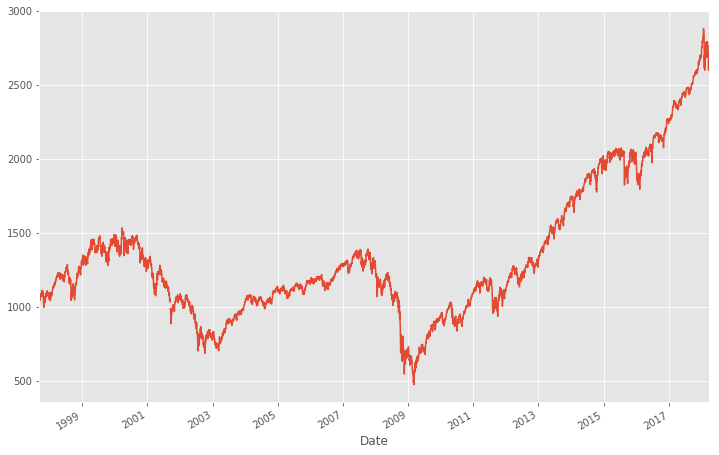

In [19]:
#Plot S&P 500 E-Mini futures series
cont_prices['ES'].plot(figsize=(12,8));